### Constantes

In [1]:
IMAGE_SIZE = 640

labels = {'standing': 0, 'takedown': 1, 'open_guard': 2, 'half_guard': 3, 'closed_guard': 4, '5050_guard': 5, 'side_control': 6, 'mount': 7, 'back': 8, 'turtle': 9}
body_parts = ["nose", "left eye", "right eye", "left ear", "right ear", "left shoulder", "right shoulder", "left elbow", "right elbow", "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle", "right ankle"]
num_labels = len(labels)
num_keypoints = 17
num_players = 2

### Importando modelo coco


In [2]:
# STEP 1: Import the necessary modules.
from ultralytics import YOLO

# Load a model
pose_model = YOLO('../../coco_model/yolov8n-pose.pt') 

### Testando modelo

In [18]:
import cv2 as cv
import matplotlib.pyplot as plt

def draw_image_with_keypoints(image_path, keypoints):
    image = cv.imread(image_path)

    image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

    for keypoint_set in keypoints:
        for i in range(num_keypoints):
            x = int(keypoint_set[i][0])
            y = int(keypoint_set[i][1])
            cv.circle(image, (x, y), 5, (255, 0, 0), -1)
        
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

### Carregando modelo pose BJJ

In [19]:
import tensorflow as tf

model = tf.keras.models.load_model("jiu_model.h5")

### Funções úteis

In [20]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np

def get_keypoints(image_path):
    predictions = pose_model(image_path)[0]
    
    if len(predictions) == 0:
        return None
    
    keypoints = predictions[0].keypoints
    keypoints_tensor = keypoints.data
    keypoints = keypoints_tensor.numpy()
    
    if len(predictions) > 1:
        keypoints2 = predictions[1].keypoints
        keypoints_tensor2 = keypoints2.data
        keypoints2 = keypoints_tensor2.numpy()
    else:
        keypoints2 = np.array([[[0, 0, 0]] * num_keypoints])
    
    keypoints = np.concatenate((keypoints, keypoints2), axis=0)
    
    return keypoints

def pose_prediction(keypoints):
    keypoints = np.array(keypoints)
    
    keypoints = keypoints.reshape(1, num_keypoints * 3 * 2)
    
    max_x = np.max(keypoints)
    
    keypoints = keypoints / max_x
    
    print("Keypoints: ", keypoints.flatten() * max_x)
    
    prediction = model.predict(keypoints)
    
    max_index = np.argmax(prediction)
    
    return max_index   

### Classificação em imagem única

image 1/1 c:\Users\guilh\Documents\bjj_ia\versions\v2\..\..\tmp\temp.jpg: 640x640 2 persons, 91.2ms
Speed: 5.5ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


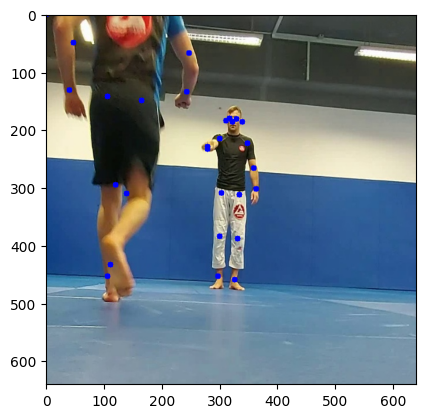

Keypoints:  [     322.97      186.02     0.98204      329.56      181.55     0.96823      317.85      180.62     0.91932      339.36      186.52     0.88887      311.38      184.44     0.58733      348.94      223.84     0.99775      300.43      215.93     0.99023      359.38      266.26     0.99006      279.41      233.28
     0.93826       363.4      302.31     0.97441      279.86      229.82     0.90795      334.43      312.52     0.99936      303.74      309.34     0.99867      331.01      388.21     0.99845      300.51      384.55     0.99701      326.18      459.28     0.99044      297.44      453.33     0.98591           0
           0   0.0020239           0           0  0.00032393           0           0  0.00032202           0           0   0.0019615           0           0   0.0019546           0           0     0.41798           0           0     0.38961      247.01      67.368      0.9297      47.344      49.743     0.91133
      243.98      134.99     0.95822      40.594 

In [21]:
import os

image_path = '../../test_images/standing.jpg'

temp_path = '../../tmp'

# resize the image
image = cv.imread(image_path)

image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

cv.imwrite(temp_path + '/temp.jpg', image)

keypoints = get_keypoints(temp_path + '/temp.jpg')

draw_image_with_keypoints(temp_path + '/temp.jpg', keypoints)

label_index = pose_prediction(keypoints)

print("Predicted Label: ", list(labels.keys())[label_index])

os.remove(temp_path + '/temp.jpg')

### Classificação em vídeo em tempo real

In [ ]:
import cv2 # type: ignore

cap = cv2.VideoCapture("../../test_videos/video.mp4")

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
    
    keypoints = get_keypoints(frame)
    
    if keypoints is None:
        continue
    
    label_index = pose_prediction(keypoints)
    
    label = list(labels.keys())[label_index]
    
    cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    for keypoint_set in keypoints:
        for i in range(num_keypoints):
            x = int(keypoint_set[i][0].item())
            y = int(keypoint_set[i][1].item())
            cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
    
    cv2.imshow("Frame", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

0: 640x640 2 persons, 81.0ms
Speed: 2.0ms preprocess, 81.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 [==============================] - 0s 20ms/step

0: 640x640 2 persons, 72.6ms
Speed: 3.0ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 [==============================] - 0s 17ms/step

0: 640x640 2 persons, 71.0ms
Speed: 2.0ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 [==============================] - 0s 18ms/step

0: 640x640 2 persons, 74.0ms
Speed: 2.0ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 [==============================] - 0s 17ms/step

0: 640x640 2 persons, 69.7ms
Speed: 1.0ms preprocess, 69.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 [==============================] - 0s 15ms/step

0: 640x640 2 persons, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at sh